In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import tifffile as tifi
import openslide
# from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# img = tifi.imread("../input/mayo-clinic-strip-ai/test/008e5c_0.tif")
# plt.imshow(cv2.flip(img, 0))
# plt.show()

# slide = openslide.open_slide("../input/mayo-clinic-strip-ai/test/008e5c_0.tif")

from openslide.deepzoom import DeepZoomGenerator

# tiles = DeepZoomGenerator(slide, tile_size=512, overlap=0, limit_bounds=False)
# print("Number of tiles:", tiles.tile_count)
# print("Number of tile levels:", tiles.level_count)
# print("Tiles levels:", tiles.level_tiles)
# print("Tiles level dimensions:", tiles.level_dimensions)
# NUM_LEVELS = 13
# # print(tiles.get_tile_dimensions(NUM_LEVELS, (5,28)))
# for i in range(tiles.level_dimensions[NUM_LEVELS][0]//512 + 1):
#     for j in range(tiles.level_dimensions[NUM_LEVELS][1]//512 + 1):
#         tile = tiles.get_tile(NUM_LEVELS, (i, j))
#         print("Tile mean value:", np.array(tile).mean())
#         print("Tile standard deviation:", np.array(tile).std())
#         plt.imshow(tile)
#         plt.show()
# # plt.imshow(tiles.get_tile(14, (0,0)))
# # plt.show()

In [2]:
# pip install pqdm

In [3]:
# from pqdm.processes import pqdm
from tqdm import tqdm

train_csv_path = "../input/mayo-clinic-strip-ai/train.csv"
train_images_path = "../input/mayo-clinic-strip-ai/train/"

test_csv_path = "../input/mayo-clinic-strip-ai/test.csv"
test_images_path = "../input/mayo-clinic-strip-ai/test/"

IMG_SIZE = 300

In [4]:
train_csv = pd.read_csv(train_csv_path)
train_csv.info()

test_csv = pd.read_csv(test_csv_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


<AxesSubplot:>

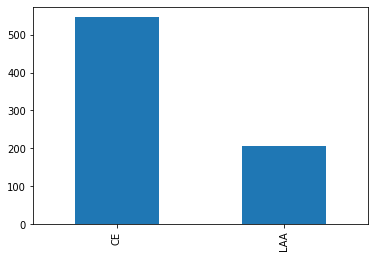

In [5]:
train_csv["label"].value_counts().plot(kind="bar")

The dataset is unbalanced

In [6]:
pip install imagesize

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [8]:
import imagesize
from tabulate import tabulate

min_w, min_h = imagesize.get("../input/mayo-clinic-strip-ai/train/006388_0.tif")
max_w, max_h = min_w, min_h
min_size = max_size = min_w * min_h
names = ["" for i in range(6)]

for image_id in tqdm(train_csv["image_id"][1:]):
    w, h = imagesize.get(train_images_path + image_id + ".tif")
    if w < min_w:
        min_w = w
        names[0] = image_id
    if w > max_w:
        max_w = w
        names[1] = image_id
    if h < min_h:
        min_h = h
        names[2] = image_id
    if h > max_h:
        max_h = h
        names[3] = image_id
    if w * h < min_size:
        min_size = w * h
        names[4] = image_id
    if w * h > max_size:
        max_size = w * h
        names[5] = image_id

data = [["size", min_size, max_size], ["width", min_w, max_w], ["hight", min_h, max_h]]
print(tabulate(data, headers=["min", "max"]))
print("Smallest image id:", names[4])
print("Largest image id:", names[5])

100%|██████████| 753/753 [00:17<00:00, 42.69it/s]

            min         max
-----  --------  ----------
size   23471938  4896084492
width      4417       99699
hight      4470      118076
Smallest image id: b43ebe_0
Largest image id: 6baf51_0


In [9]:
import tensorflow as tf

Create tfrecords

In [10]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def parse_single_image(image, label):
    #define the dictionary -- the structure -- of our single example
    data = {
        'raw_image' : _bytes_feature(serialize_array(image)),
        'label' : _int64_feature(label)
    }
    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    return out

def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'label':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }
    content = tf.io.parse_single_example(element, data)
    
    label = content['label']
    raw_image = content['raw_image']
    
    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
    feature = tf.reshape(feature, shape=[IMG_SIZE, IMG_SIZE,3])
    return (feature, label)

def write_images_to_tfr(images, labels, image_id:str, filename:str="train_records", max_files:int=10, start:int=0):
    #determine the number of shards (single TFRecord files) we need:
    splits = (len(images)//max_files) + 1 #determine how many tfr shards are needed
    if len(images) % max_files == 0:
        splits -= 1
        print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

    file_count = 0
    for i in tqdm.tqdm(range(splits)):
        current_shard_name = "{}_{}{}.tfrecords".format(image_id, start+i+1, filename)
        writer = tf.io.TFRecordWriter(current_shard_name)

        current_shard_count = 0
        while current_shard_count < max_files: #as long as our shard is not full
            #get the index of the file that we want to parse now
            index = i*max_files+current_shard_count
            if index == len(images): #when we have consumed the whole data, preempt generation
                break
            current_image = images[index]
            current_label = labels[index]

            #create the required Example representation
            out = parse_single_image(image=current_image, label=current_label)
            writer.write(out.SerializeToString())
            current_shard_count+=1
            file_count += 1

    writer.close()
    print(f"\nWrote {file_count} elements to TFRecord")
    return file_count

In [11]:
from PIL import Image

try:
    os.makedirs("./white")
    os.makedirs("./usable")
except:
    pass
white_images_count = 0
useful_images_count = 0
# for image_id in tqdm(test_csv["image_id"]):
for i in range(len(test_csv["image_id"])):
    image_id = test_csv["image_id"][i]
    patient_id = test_csv["patient_id"][i]
    print(patient_id)
    slide = openslide.open_slide(test_images_path + image_id + ".tif")
    tiles = DeepZoomGenerator(slide, tile_size=IMG_SIZE, overlap=0, limit_bounds=False)
    NUM_LEVELS = tiles.level_count - 2
    useful_images = []
    try:
        os.makedirs("./white/" + patient_id + "/" + patient_id)
        os.makedirs("./usable/" + patient_id + "/" + patient_id)
    except:
        pass
    for i in range(tiles.level_dimensions[NUM_LEVELS][0]//IMG_SIZE + 1):
        for j in range(tiles.level_dimensions[NUM_LEVELS][1]//IMG_SIZE + 1):
            tile = tiles.get_tile(NUM_LEVELS, (i, j))
            ##seperate white tiles
            if np.array(tile).mean() > 230 and np.array(tile).std() < 35:
#                 tile.save("./white/" + patient_id + "/" + patient_id + "/" + image_id + "_" + str(i) + "," + str(j) + ".jpg")
                white_images_count += 1
            else:
                useful_images_count += 1
                useful_images.append(np.array(tile))
                tile.save("./usable/" + patient_id + "/" + patient_id + "/" + image_id + "_" + str(i) + "," + str(j) + ".jpg")

006388
008e5c
00c058
01adc5


In [12]:
##print(len(os.listdir("./usable")))
##print(len(os.listdir("./white")))

Decode images from tfrecords

In [13]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
          'label':tf.io.FixedLenFeature([], tf.int64),
          'raw_image' : tf.io.FixedLenFeature([], tf.string)
        }
        if labeled
        else {"raw_image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["raw_image"])
    if labeled:
        label = tf.cast(example["label"], tf.int32)
        return image, label
    return image
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        parse_tfr_element, num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset